In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import cv2
import gdown
import seaborn as sns
#%matplotlib inline

In [2]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
model = tf.keras.models.load_model('trained-model-eeg')

In [6]:
# Load test datasets.

test_url = 'https://drive.google.com/uc?id=16LYmLmOb--tXGCAn3YMIetSqGKgmB-b8'
test_ = 'df_test.json'

gdown.download(test_url, test_, quiet=False)
df_test = pd.read_json(test_)

Downloading...
From: https://drive.google.com/uc?id=16LYmLmOb--tXGCAn3YMIetSqGKgmB-b8
To: c:\Users\dheer\WHK\EEG-Non_EEG-XAI-analysis-main\EEG-Non_EEG-XAI-analysis-main\EEG\df_test.json
100%|██████████| 6.76M/6.76M [00:03<00:00, 1.92MB/s]


(98.75, <AxesSubplot:>)

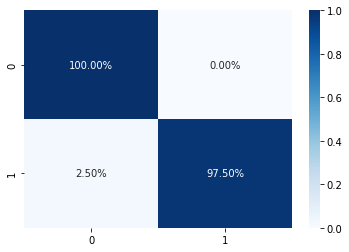

In [10]:
# Prepare test data for evaluation

x_test = np.array([np.array(xi, dtype='float32') for xi in df_test['Data']])
y_test = np.asarray(df_test['Label'])
x_test_std = x_test.std()
x_test_mean = x_test.mean()

nb_classes = 2
y_test = (y_test - y_test.min())/(y_test.max()-y_test.min())*(nb_classes-1)
Y_test = keras.utils.to_categorical(y_test, nb_classes)
x_test = (x_test - x_test_mean)/(x_test_std)
x_test = x_test.reshape(x_test.shape + (1,))
pred = model.predict(x_test)
pred = list(pred)
y_pred = np.argmax(pred, axis=1)
cm = confusion_matrix(np.int16(y_test), y_pred, normalize='true')
acc = accuracy_score(np.int16(y_test), y_pred)*100;

acc, sns.heatmap(cm/np.sum(cm, axis=1), annot=True, fmt='.2%', cmap='Blues')

In [11]:
# CAM

get_last_conv = keras.backend.function([model.layers[0].input], [model.layers[-3].output])
last_conv = get_last_conv([x_test])[0]
get_softmax = keras.backend.function([model.layers[0].input], [model.layers[-1].output])
softmax = get_softmax(([x_test]))[0]
softmax_weight = model.get_weights()[-2]
CAM = np.dot(last_conv, softmax_weight)

x_test = (x_test * x_test_std) + x_test_mean

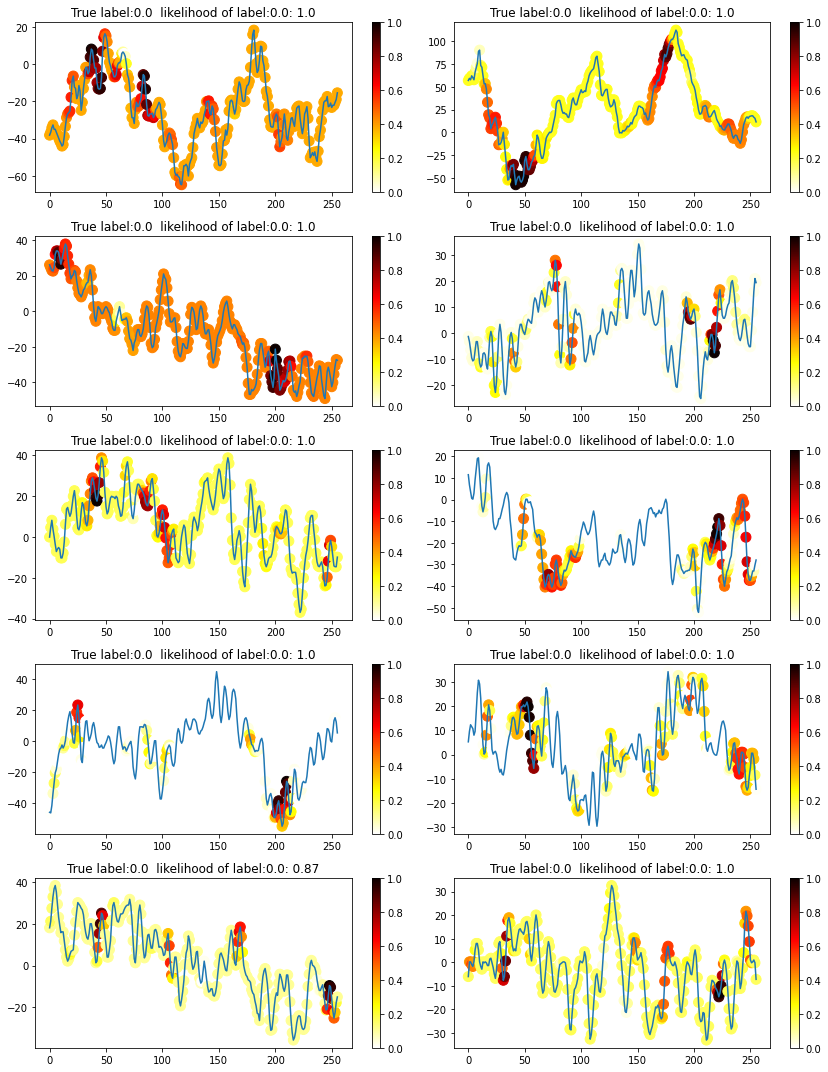

In [12]:
a = 5  # number of rows
b = 2  # number of columns
d = 1  # initialize plot counter
plt.figure(figsize=(12, 15))
index= 0
num_seg = 10

for k in range(index*num_seg, num_seg + index*num_seg):
    feat = 0
    c = (CAM - CAM.min(axis=1, keepdims=True)) / (CAM.max(axis=1, keepdims=True) - CAM.min(axis=1, keepdims=True)) #min-max normalization
    #c = np.exp(CAM) / np.sum(np.exp(CAM), axis=1, keepdims=True)
    
    plt.subplot(a, b, d)
    plt.title('True label:' + str(y_test[k]) + '  likelihood of label:' + str(y_test[k]) + ': ' + 
              str(round(softmax[k][int(y_test[k])], 2)))
    plt.plot(x_test[k, :, 0].squeeze(), );  
    plt.scatter(np.arange(len(x_test[k])), x_test[k, :, 0].squeeze(), 
                cmap='hot_r', c=c[k, :, 0, int(y_test[k])].squeeze(), s=100);   #np.arange(len(x_val[k])
    plt.colorbar();
    d = d + 1
plt.tight_layout()
plt.show()

In [13]:
elec = np.arange(0,24)
elec

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [14]:
def grad_cam(image, model, model_layer, color=False):
    
    img_bgr = image
    
    if color==True:
        test_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        test_img = np.expand_dims(test_img, axis=0)
    else:
        test_img = img_bgr
        test_img = np.expand_dims(test_img, axis=0)
    
    last_conv_layer = model.get_layer(model_layer) #model.get_layer("conv2d_7") 
    heatmap_model = tf.keras.models.Model(inputs=model.input,
                                          outputs=[last_conv_layer.output, model.output])
    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(test_img)
        loss = predictions[:, np.argmax(predictions[0])]
        grads = gtape.gradient(loss, conv_output)
        pooled_grads = tf.keras.backend.mean(grads, axis=(0, 1, 2))#, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    
    img_bgr = cv2.cvtColor(img_bgr, cv2.COLOR_GRAY2RGB)
    img_bgr = (((img_bgr - img_bgr.min())/(img_bgr.max()-img_bgr.min())) * 255).astype(np.uint8)
    
    squeezed_hm = np.squeeze(heatmap)
    normalized_hm = cv2.resize(squeezed_hm, (img_bgr.shape[1], img_bgr.shape[0]))
    
    normalized_hm = (255 * normalized_hm).astype(np.uint8)
    normalized_hm = cv2.applyColorMap(normalized_hm, cv2.COLORMAP_JET)
    
    rows, cols = 1, 1
    fig, axs = plt.subplots(rows, cols, figsize=(50, 15))
    
    plt.setp(axs, yticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23], yticklabels=elec)    
    
    ax2 = axs.imshow(cv2.cvtColor(normalized_hm.transpose(1, 0, 2), cv2.COLOR_BGR2RGB), cmap='jet', vmin=0, vmax=1)
    axs.set_title('Normalized Grad-CAM | Label 0')
    fig.colorbar(ax2, ax=axs, shrink=0.1);
    
    return heatmap


In [15]:
x_test = (x_test - x_test_mean)/(x_test_std)

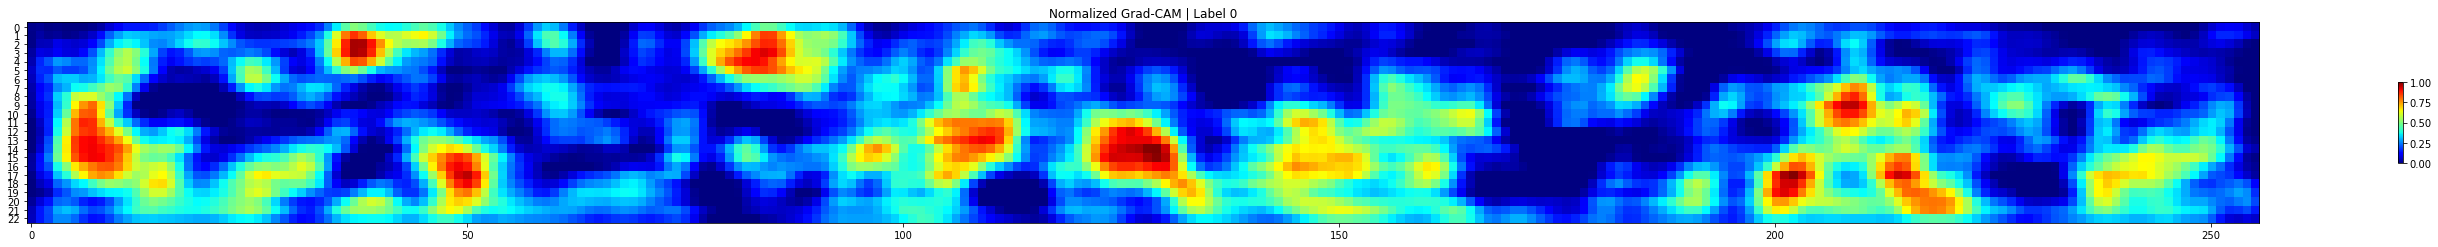

In [16]:
last_conv_layer = 'conv2d_23'

#for i in range(subject*num_seg, num_seg + subject*num_seg):
norm_hm = grad_cam(x_test[0].squeeze(), model=model, model_layer=last_conv_layer, color=False)

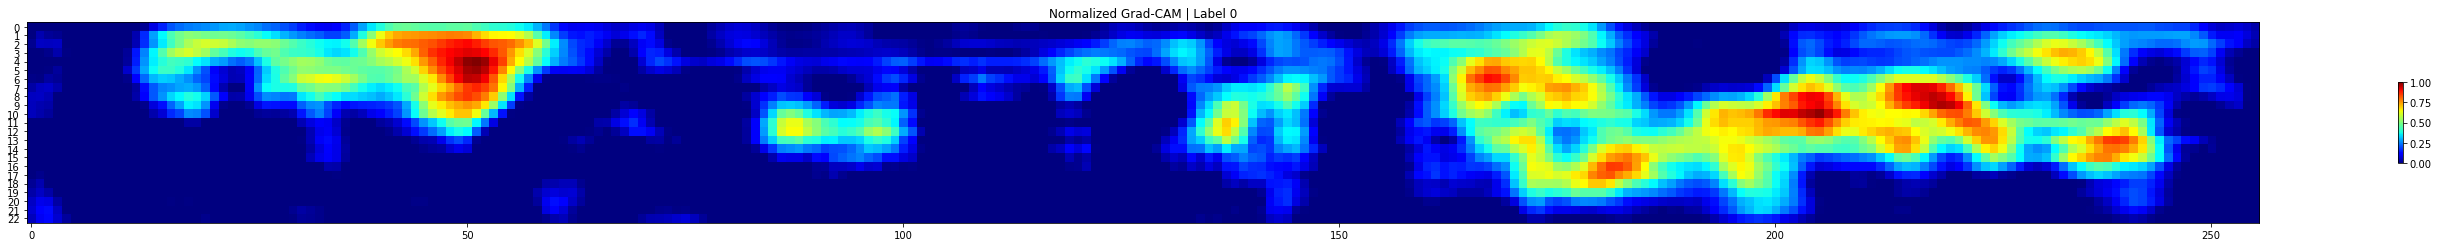

In [17]:
last_conv_layer = 'conv2d_23'
norm_hm = grad_cam(x_test[1].squeeze(), model=model, model_layer=last_conv_layer, color=False)